In [1]:
suppressPackageStartupMessages({
    
    library(limma)
    library(rrcovNA)
    library(imputeLCMD)


    library(ggplot2)
    library(patchwork)
    library(ggsci)
    library(ggExtra)
    
})


options(warn = -1)


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}


devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")

masterMix_proteins <- c("P02754","P80025","P00921","P00366","P02662","P61823",
                        "P02789","P12799","P02676","P02672", "P02666","P68082") 

ℹ Loading msImpute



### Read data and filter

In [2]:
data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PASS00589/Standard-Profiling-Sample-Set/combined/txt/evidence.txt", stringsAsFactors = FALSE)


# data <- data[grep("CON_|REV_", data$Leading.razor.protein, invert=TRUE),]
data <- data[data$Charge > 1,]
data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")


genes <- data[,c("PeptideID","matrix.row.id", "Leading.Razor.Protein")]
genes <- genes[!duplicated(genes),]


y <- evidenceToMatrix(data)
genes <- genes[match(rownames(y), genes$PeptideID),]


y_dda <- log2(y)

rownames(y) <- genes$matrix.row.id[match(rownames(y), genes$PeptideID)]
rownames(y_dda) <- genes$matrix.row.id[match(rownames(y_dda), genes$PeptideID)]


keep3 <- (!grepl("CON__|REV__", genes$Leading.Razor.Protein))
keep4 <- (!grepl("[a-z]+", genes$PeptideID))

y_dda <- y_dda[keep3&keep4,]
y <- y[keep3&keep4,]



group <- gsub(".*_SGSDS(sample[1-8])_(R0[1-3])_MSG",
              "\\1",
              colnames(y_dda))

design <- model.matrix(~ group)

### Imputation (barycenter + SOTA methods)

In [3]:
y_msImpute <- msImpute(y_dda[rowSums(!is.na(y_dda)) >= 4,], 
                       method = "v2-mnar", 
                       group = group)

Running msImpute version 2

Estimate distribution under MAR assumption

rank is 16

computing lambda0 ...

lambda0 is 156.582715167033

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar



In [4]:
y_MLE <- impute.wrapper.MLE(y_dda)
y_impSeq <- impSeq(y_dda)
y_knn <- impute.wrapper.KNN(y_dda, K = 15)


y_minDet <- impute.MinDet(y_dda, q = 0.01)


y_perseus <- impute.perseus(y_dda)

# pcv <- plotCV2(limma::normalizeBetweenArrays(y_perseus,
#                                              method = 'quantile'), 
#                main = "perseus")

y_qrilc <- impute.QRILC(y_dda, 1)[[1]]


sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_PASS00589_DDA_sOa_filter4obs_noNorm.rds")



names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])




Cluster size 34260 broken into 15356 18904 
Cluster size 15356 broken into 5965 9391 
Cluster size 5965 broken into 2823 3142 
Cluster size 2823 broken into 1441 1382 
Done cluster 1441 
Done cluster 1382 
Done cluster 2823 
Cluster size 3142 broken into 1398 1744 
Done cluster 1398 
Cluster size 1744 broken into 1063 681 
Done cluster 1063 
Done cluster 681 
Done cluster 1744 
Done cluster 3142 
Done cluster 5965 
Cluster size 9391 broken into 7171 2220 
Cluster size 7171 broken into 2344 4827 
Cluster size 2344 broken into 2048 296 
Cluster size 2048 broken into 182 1866 
Done cluster 182 
Cluster size 1866 broken into 152 1714 
Done cluster 152 
Cluster size 1714 broken into 429 1285 
Done cluster 429 
Done cluster 1285 
Done cluster 1714 
Done cluster 1866 
Done cluster 2048 
Done cluster 296 
Done cluster 2344 
Cluster size 4827 broken into 4775 52 
Cluster size 4775 broken into 3141 1634 
Cluster size 3141 broken into 1728 1413 
Cluster size 1728 broken into 1683 45 
Cluster size

In [5]:
#rowsname <- rownames(y_msImpute)
rowsname <- rownames(y)[rownames(y) %in% m]

mats <- list(
             "KNN"= y_knn[rowsname,],
            
             "impSeq" = y_impSeq[rowsname,],
             
             "barycenter" = y_msImpute, 
             
             "baseline" = y[rowsname,])





mats <- c(sOa_imps, mats)

### Differential abundance testing

In [6]:
n_ups <- 500


topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   E <- normalizeBetweenArrays(mats[[i]], method = "quantile")

   fit <- lmFit(E, design = design)

   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  tp$de <- ifelse(tp$adj.P.Val < 0.05,1,0)
  tp$isUPS <- ifelse(gsub("(.*)_(.*)_(.*)","\\3", rownames(tp)) %in% masterMix_proteins,1,0)
  #tp$isdeUPS <- ifelse(tp$isUPS==1 & tp$de==1,1,0)
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                       #numUPS=cumsum(tp$TP)[seq_len(n_ups)],
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > 0.05)[1],1,0),
                                       method=names(mats)[i])
  
  

  fullTables[[names(mats)[i]]] <- data.frame(
    

    
    # replace with labels and predictions to use pROC
    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  
  fullTables2[[names(mats)[i]]] <- data.frame(
    
    
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE)
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))


fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))
fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))


processing RF



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           66          101          103
NotSig           0        25286        25219        25184        25089
Up           25286            0            1            1           94
       groupsample6 groupsample7 groupsample8
Down            103          105          893
NotSig        25066        25054        23516
Up              117          127          877


processing Mice



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           31           94          255
NotSig           0        25286        25255        25183        24786
Up           25286            0            0            9          245
       groupsample6 groupsample7 groupsample8
Down            263          255         1071
NotSig        24765        24787        23173
Up              258          244         1042


processing EM



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           58           83          116
NotSig           0        25286        25227        25201        25077
Up           25286            0            1            2           93
       groupsample6 groupsample7 groupsample8
Down            105          131         1087
NotSig        25068        25002        23134
Up              113          153         1065


processing BPCA



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           49           72           87
NotSig           0        25286        25236        25213        25133
Up           25286            0            1            1           66
       groupsample6 groupsample7 groupsample8
Down             71           78         1141
NotSig        25143        25111        22852
Up               72           97         1293


processing KNN



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0            8           60           74
NotSig           0        25286        25277        25225        25166
Up           25286            0            1            1           46
       groupsample6 groupsample7 groupsample8
Down             68           71          208
NotSig        25164        25148        24869
Up               54           67          209


processing impSeq



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            0           54          101          400
NotSig           0        25286        25232        25182        24448
Up           25286            0            0            3          438
       groupsample6 groupsample7 groupsample8
Down            468          540         1899
NotSig        24283        24099        21491
Up              535          647         1896


processing barycenter



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0            1            3           65          113
NotSig           0        25283        25282        25213        25083
Up           25286            2            1            8           90
       groupsample6 groupsample7 groupsample8
Down            122          133          268
NotSig        25060        25027        24696
Up              104          126          322


processing baseline



       (Intercept) groupsample2 groupsample3 groupsample4 groupsample5
Down             0           15           62           83           43
NotSig        2908        21559        21676        22080        22036
Up           22378            1            3            2           40
       groupsample6 groupsample7 groupsample8
Down             39           29          185
NotSig        21756        21474        18262
Up               52           50          188


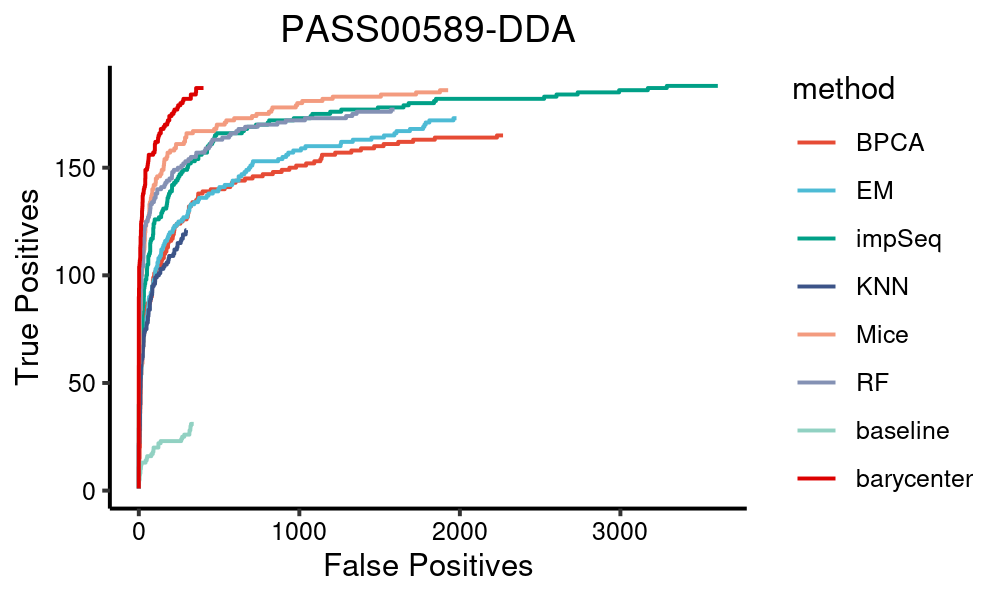

In [7]:
fig.size(3, 5)

# ROC curves
p1 <- ggplot(fullTables2, aes(y=TP, x=FP, color=method, group = method)) +
#   geom_line(size=1) + 
    geom_line() +
   scale_color_npg() +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5), axis.text=element_text(colour="black")) + 
  labs(title = "PASS00589-DDA") + xlab("False Positives") + ylab("True Positives")

p1

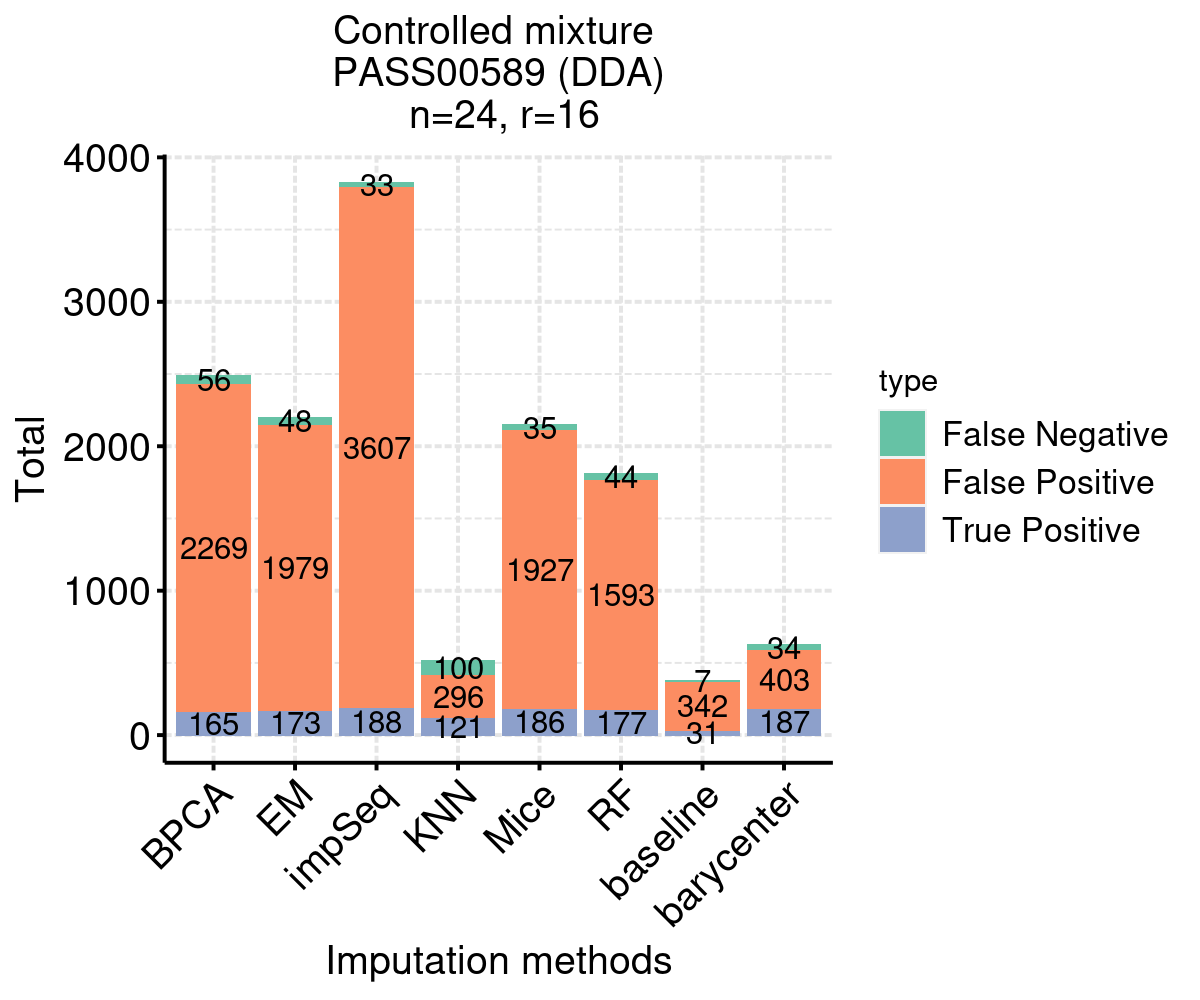

In [8]:
fig.size(5,6)

# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05
ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)


# png(file = "~/barplot_PASS00589.png",
#     width=6,height=5,units="in",res=1200)

p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +
  geom_text(position = position_stack(vjust = 0.5)) +
  xlab('Imputation methods') + ylab('Total') + labs(fill="type", title = "Controlled mixture \nPASS00589 (DDA)\n n=24, r=16") +  
  # scale_fill_jco() +
  scale_fill_brewer(palette = "Set2") +
  #scale_fill_brewer(palette = "Dark2", direction = -1) +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

# print(p)
# dev.off()
p


FALSE  TRUE 
14727 10559 

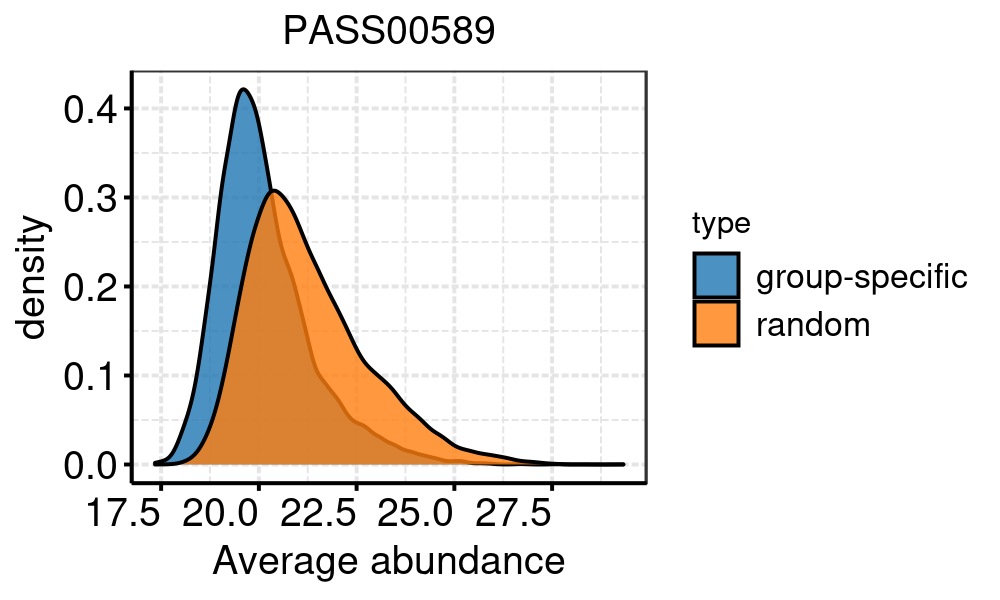

In [9]:
fig.size(3,5)


# Visualization of the ebm metric for assessment of missing types
hdp <- selectFeatures(y_dda[rowSums(!is.na(y_dda)) >= 4,],
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)




ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")

# png(file = "~/hist_missingtype_PASS00589.png",
#     width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PASS00589", x="Average abundance")  +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

# print(p)
# dev.off()
p

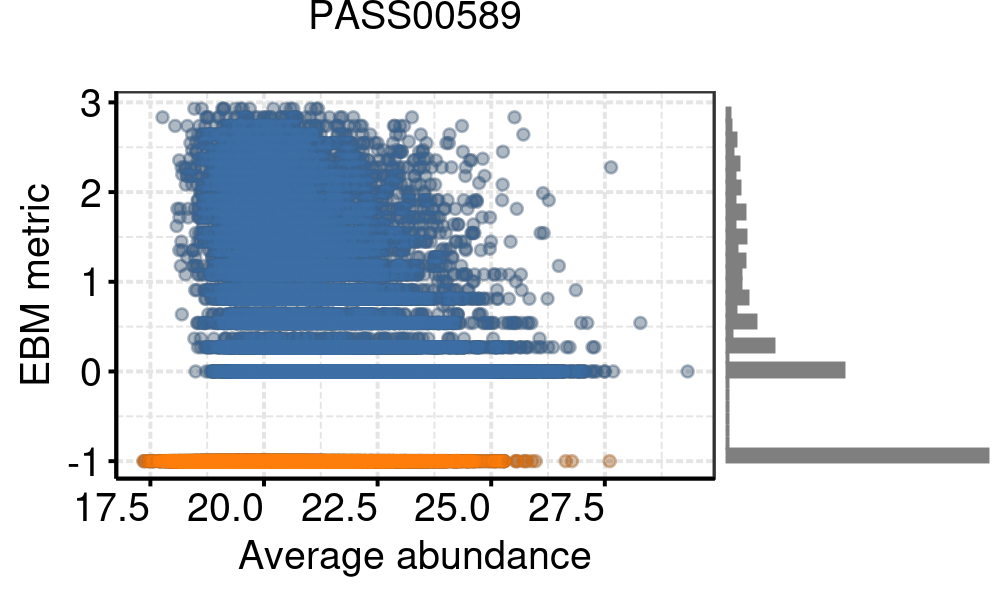

In [10]:
fig.size(3,5)


# EBM vs Ave abundance
p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, 
             color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average abundance', y = 'EBM metric', title = "PASS00589")

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)


# png(file = "~/scatter_ebm_abundance_PASS00589.png",
#     width=5,height=3,units="in",res=1200)

# print(p1)
# dev.off()
p1

### Session information

In [11]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.1.2/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] msImpute_1.3.3      ggExtra_0.9         ggsci_2.9          
 [4] patchwork_1.1.1     ggplot2_3.3.4       imputeLCMD_2.0     
 [7] impute_1.66.0       pcaMethods_1.84.0   Biobase_2.52.0     
[10] BiocGenerics_0.38